In [1]:
import os

In [2]:
folder = 'Данные_Эксперимент_4'

## Загрузка данных

In [3]:
import json

# Входные данные
with open(os.path.join(folder, 'description_text.json'), 'r') as f:
    description_text = json.load(f)

## Признаки
with open(os.path.join(folder, 'index_1_labels.json'), 'r') as f:
    index_1_labels = json.load(f)

with open(os.path.join(folder, 'index_2_labels.json'), 'r') as f:
    index_2_labels = json.load(f)

with open(os.path.join(folder, 'index_3_labels.json'), 'r') as f:
    index_3_labels = json.load(f)

with open(os.path.join(folder, 'index_4_labels.json'), 'r') as f:
    index_4_labels = json.load(f)

with open(os.path.join(folder, 'index_5_labels.json'), 'r') as f:
    index_5_labels = json.load(f)

In [4]:
# NUM_INDEXES = len(dictionary)
MAX_LENGTH = 256

NUM_1_CLASSES = len(set(index_1_labels))
NUM_2_CLASSES = len(set(index_2_labels))
NUM_3_CLASSES = len(set(index_3_labels))
NUM_4_CLASSES = len(set(index_4_labels))
NUM_5_CLASSES = len(set(index_5_labels))

In [5]:
NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES

(3, 3, 13, 24, 257)

## Предобученная модель

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [7]:
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [8]:
from transformers import AutoModelForSequenceClassification, AutoConfig

In [9]:
MODEL_NAME = 'bert-base-multilingual-cased'

In [10]:
bert_config = AutoConfig.from_pretrained(MODEL_NAME)
bert_config.output_hidden_states = True
backbone = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=bert_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Заморозить обучение всех параметров модели
for param in backbone.parameters():
    param.requires_grad = False

## Датасет

In [12]:
from transformers import AutoTokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [14]:
description_indexes = [tokenizer(item,
                       padding='max_length',
                       max_length = MAX_LENGTH,
                       truncation=True)['input_ids'] for item in description_text]

In [15]:
description_masks = [tokenizer(item,
                       padding='max_length',
                       max_length = MAX_LENGTH,
                       truncation=True)['attention_mask'] for item in description_text]

In [16]:
import torch
from torch.utils.data import DataLoader, Dataset

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
class SentDataset(Dataset):

    def __init__(self, indexes, masks, labels, max_len=None):
        self.indexes = indexes
        self.masks = masks
        self.labels_1 = labels[0]
        self.labels_2 = labels[1]
        self.labels_3 = labels[2]
        self.labels_4 = labels[3]
        self.labels_5 = labels[4]

    def __getitem__(self, i):

        row = self.indexes[i]
        mask = self.masks[i]
        label_1 = self.labels_1[i]
        label_2 = self.labels_2[i]
        label_3 = self.labels_3[i]
        label_4 = self.labels_4[i]
        label_5 = self.labels_5[i]

        x = torch.tensor(row, dtype=torch.long, device=device)
        x_m = torch.tensor(mask, dtype=torch.long, device=device)
        y1 = torch.tensor(label_1, dtype=torch.long, device=device)
        y2 = torch.tensor(label_2, dtype=torch.long, device=device)
        y3 = torch.tensor(label_3, dtype=torch.long, device=device)
        y4 = torch.tensor(label_4, dtype=torch.long, device=device)
        y5 = torch.tensor(label_5, dtype=torch.long, device=device)

        return ((x, x_m), (y1, y2, y3, y4, y5))

    def __len__(self):
        return len(self.indexes)

In [19]:
dataset = SentDataset(description_indexes,
                      description_masks,
                      (index_1_labels, index_2_labels, index_3_labels, index_4_labels, index_5_labels))

In [20]:
X, y = dataset[10]
X, y

((tensor([   101,  10439,  33649,  15061, 108515,  10375,  30604,  10353,  36035,
           37574,  10475,  61394,  66045,    546,  18705,  17371,    119,  90363,
           11851,  14122,  10913,  41102,  46920,  10292,  37178,  10234,  53204,
           22523,  10517,  10475,  61394,  89465,  10227,    546,  18705,  17371,
           48495,  61995,  77362,  11911,  19528,  12964,  10320,  51965,  10510,
           51965,  10510, 105466,  43900,  10161,  10387,  66991,  14655,  10297,
           25263,  59808,  11279,  13976,  10375,  10956,  10353,  32229,  20292,
           18494,  33190,  10332, 107084,  11258,  10949,  11663,    136,    558,
          107528,  29709,    119,    102,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0,      0,      0,      0,      0,      0,      0,      0,      0,
               0

In [21]:
total_samples = len(dataset)
train_samples = int(0.7 * total_samples)
train_indices = list(range(train_samples))
test_indices = list(range(train_samples, total_samples))
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [73]:
batch_size = 512

In [74]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

## Модель

In [61]:
import torch.nn as nn
import torch.nn.functional as F

In [62]:
class CustomModel(nn.Module):
    def __init__(self, backbone, hidden_size, output_size):
        super(CustomModel, self).__init__()

        self.hidden_size = hidden_size

        self.output_size_1 = output_size[0]
        self.output_size_2 = output_size[1]
        self.output_size_3 = output_size[2]
        self.output_size_4 = output_size[3]
        self.output_size_5 = output_size[4]

        self.backbone = backbone
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.dense1 = nn.Linear(backbone.config.hidden_size, hidden_size)

        self.fc_1 = nn.Linear(hidden_size, output_size[0])
        self.fc_2 = nn.Linear(hidden_size, output_size[1])
        self.fc_3 = nn.Linear(hidden_size, output_size[2])
        self.fc_4 = nn.Linear(hidden_size, output_size[3])
        self.fc_5 = nn.Linear(hidden_size, output_size[4])

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids, attention_mask=attention_mask)
        features = outputs.hidden_states[-1]
        pooled = self.pooling(features.permute(0, 2, 1)).squeeze(2)
        dense1 = self.dense1(pooled)
        dense1 = F.relu(dense1)

        output_1 = self.fc_1(dense1)
        output_2 = self.fc_2(dense1)
        output_3 = self.fc_3(dense1)
        output_4 = self.fc_4(dense1)
        output_5 = self.fc_5(dense1)

        output_1 = F.softmax(output_1, dim=1)
        output_2 = F.softmax(output_2, dim=1)
        output_3 = F.softmax(output_3, dim=1)
        output_4 = F.softmax(output_4, dim=1)
        output_5 = F.softmax(output_5, dim=1)
        return (output_1, output_2, output_3, output_4, output_5, )

In [75]:
# input_size = NUM_INDEXES
hidden_size = 84
output_size = (NUM_1_CLASSES, NUM_2_CLASSES, NUM_3_CLASSES, NUM_4_CLASSES, NUM_5_CLASSES)

In [76]:
model = CustomModel(backbone, hidden_size, output_size).to(device)

## Функции обучения

In [65]:
import torch.optim as optim

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [67]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 dense1.weight
	 dense1.bias
	 fc_1.weight
	 fc_1.bias
	 fc_2.weight
	 fc_2.bias
	 fc_3.weight
	 fc_3.bias
	 fc_4.weight
	 fc_4.bias
	 fc_5.weight
	 fc_5.bias


In [68]:
def train(model, iterator, criterion, optimizer, scheduler=None):
    model.train()
    sum_loss_1 = 0.0
    sum_loss_2 = 0.0
    sum_loss_3 = 0.0
    sum_loss_4 = 0.0
    sum_loss_5 = 0.0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    correct_5 = 0
    total = 0
    num_batch = 0
    for iter_, (X, y) in enumerate(iterator):
        optimizer.zero_grad()
        text = X[0].to(device)
        mask = X[1].to(device)
        labels = [label.to(device) for label in y]
        predictions = model(text, mask)

        loss_1 = criterion(predictions[0], labels[0])
        loss_2 = criterion(predictions[1], labels[1])
        loss_3 = criterion(predictions[2], labels[2])
        loss_4 = criterion(predictions[3], labels[3])
        loss_5 = criterion(predictions[4], labels[4])
        sum_loss_1 += loss_1.item()
        sum_loss_2 += loss_2.item()
        sum_loss_3 += loss_3.item()
        sum_loss_4 += loss_4.item()
        sum_loss_5 += loss_5.item()

        ((loss_1+loss_2+loss_3+loss_4+loss_5)/5).backward()

        optimizer.step()

        num_batch += 1
        predicted_classes_1 = torch.argmax(predictions[0], dim=1)
        predicted_classes_2 = torch.argmax(predictions[1], dim=1)
        predicted_classes_3 = torch.argmax(predictions[2], dim=1)
        predicted_classes_4 = torch.argmax(predictions[3], dim=1)
        predicted_classes_5 = torch.argmax(predictions[4], dim=1)
        correct_1 += (predicted_classes_1 == labels[0]).sum().item()
        correct_2 += (predicted_classes_2 == labels[1]).sum().item()
        correct_3 += (predicted_classes_3 == labels[2]).sum().item()
        correct_4 += (predicted_classes_4 == labels[3]).sum().item()
        correct_5 += (predicted_classes_5 == labels[4]).sum().item()
        total += labels[0].size(0)

        if iter_*batch_size % 1600 == 0:
            print(iter_*batch_size)

    accuracy_1 = correct_1 / total
    accuracy_2 = correct_2 / total
    accuracy_3 = correct_3 / total
    accuracy_4 = correct_4 / total
    accuracy_5 = correct_5 / total
    sum_loss_1 /= len(iterator)
    sum_loss_2 /= len(iterator)
    sum_loss_3 /= len(iterator)
    sum_loss_4 /= len(iterator)
    sum_loss_5 /= len(iterator)

    if scheduler:
        scheduler.step()

    return (
        (round(sum_loss_1, 4), round(sum_loss_2, 4), round(sum_loss_3, 4), round(sum_loss_4, 4), round(sum_loss_5, 4)),
        (round(accuracy_1, 4), round(accuracy_2, 4), round(accuracy_3, 4), round(accuracy_4, 4), round(accuracy_5, 4), )
    )

In [52]:
# Процесс оценки
def evaluate(model, iterator, criterion):
    model.eval()
    sum_loss_1 = 0.0
    sum_loss_2 = 0.0
    sum_loss_3 = 0.0
    sum_loss_4 = 0.0
    sum_loss_5 = 0.0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    correct_4 = 0
    correct_5 = 0
    total = 0
    with torch.no_grad():
        for iter_, (X, y) in enumerate(iterator):
            text = X[0].to(device)
            mask = X[1].to(device)
            labels = [label.to(device) for label in y]
            predictions = model(text, mask)

            sum_loss_1 += criterion(predictions[0], labels[0]).item()
            sum_loss_2 += criterion(predictions[1], labels[1]).item()
            sum_loss_3 += criterion(predictions[2], labels[2]).item()
            sum_loss_4 += criterion(predictions[3], labels[3]).item()
            sum_loss_5 += criterion(predictions[4], labels[4]).item()

            predicted_classes_1 = torch.argmax(predictions[0], dim=1)
            predicted_classes_2 = torch.argmax(predictions[1], dim=1)
            predicted_classes_3 = torch.argmax(predictions[2], dim=1)
            predicted_classes_4 = torch.argmax(predictions[3], dim=1)
            predicted_classes_5 = torch.argmax(predictions[4], dim=1)
            correct_1 += (predicted_classes_1 == labels[0]).sum().item()
            correct_2 += (predicted_classes_2 == labels[1]).sum().item()
            correct_3 += (predicted_classes_3 == labels[2]).sum().item()
            correct_4 += (predicted_classes_4 == labels[3]).sum().item()
            correct_5 += (predicted_classes_5 == labels[4]).sum().item()
            total += labels[0].size(0)

#             if iter_*batch_size % 10 == 0:
#                 print(iter_*batch_size)

    accuracy_1 = correct_1 / total
    accuracy_2 = correct_2 / total
    accuracy_3 = correct_3 / total
    accuracy_4 = correct_4 / total
    accuracy_5 = correct_5 / total
    sum_loss_1 /= len(iterator)
    sum_loss_2 /= len(iterator)
    sum_loss_3 /= len(iterator)
    sum_loss_4 /= len(iterator)
    sum_loss_5 /= len(iterator)

    return  (
        (round(sum_loss_1, 4), round(sum_loss_2, 4), round(sum_loss_3, 4), round(sum_loss_4, 4), round(sum_loss_5, 4)),
        (round(accuracy_1, 4), round(accuracy_2, 4), round(accuracy_3, 4), round(accuracy_4, 4), round(accuracy_5, 4), )
    )

In [69]:
from IPython.display import clear_output

In [72]:
data = {
    'train_loss': [[], [], [], [], []],
    'train_accuracy': [[], [], [], [], []],
    'test_loss': [[], [], [], [], []],
    'test_accuracy': [[], [], [], [], []],
}

## Функции для визуализации

In [55]:
from matplotlib import pyplot as plt

In [56]:
def plot_learning_curves(data):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 20))

    plt.subplot(2,2,1)
    plt.title('Обучение. Лосс', fontsize=15)
    plt.plot(data['train_loss'][0], label='label 1')
    plt.plot(data['train_loss'][1], label='label 2')
    plt.plot(data['train_loss'][2], label='label 3')
    plt.plot(data['train_loss'][3], label='label 4')
    plt.plot(data['train_loss'][4], label='label 5')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Обучение. Точность', fontsize=15)
    plt.plot(data['train_accuracy'][0], label='label 1')
    plt.plot(data['train_accuracy'][1], label='label 2')
    plt.plot(data['train_accuracy'][2], label='label 3')
    plt.plot(data['train_accuracy'][3], label='label 4')
    plt.plot(data['train_accuracy'][4], label='label 5')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Тест. Лосс', fontsize=15)
    plt.plot(data['test_loss'][0], label='label 1')
    plt.plot(data['test_loss'][1], label='label 2')
    plt.plot(data['test_loss'][2], label='label 3')
    plt.plot(data['test_loss'][3], label='label 4')
    plt.plot(data['test_loss'][4], label='label 5')
    plt.ylabel('Лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('Тест. Точность', fontsize=15)
    plt.plot(data['test_accuracy'][0], label='label 1')
    plt.plot(data['test_accuracy'][1], label='label 2')
    plt.plot(data['test_accuracy'][2], label='label 3')
    plt.plot(data['test_accuracy'][3], label='label 4')
    plt.plot(data['test_accuracy'][4], label='label 5')
    plt.ylabel('Точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.show()

In [57]:
def updata(data):
    for place, item in zip(data['train_loss'], train_loss):
        place.append(item)

    for place, item in zip(data['train_accuracy'], train_accuracy):
        place.append(item)

    for place, item in zip(data['test_loss'], test_loss):
        place.append(item)

    for place, item in zip(data['test_accuracy'], test_accuracy):
        place.append(item)

    return data

## Обучение

Epoch: 50
Train loss: (0.8434, 0.9495, 2.3366, 2.9824, 5.3851)
Train accuracy: (0.7079, 0.5841, 0.3632, 0.265, 0.1708)
Test loss: (0.7865, 0.9656, 2.2904, 2.9927, 5.3948)
Test accuracy: (0.7649, 0.5677, 0.4126, 0.2548, 0.1615)


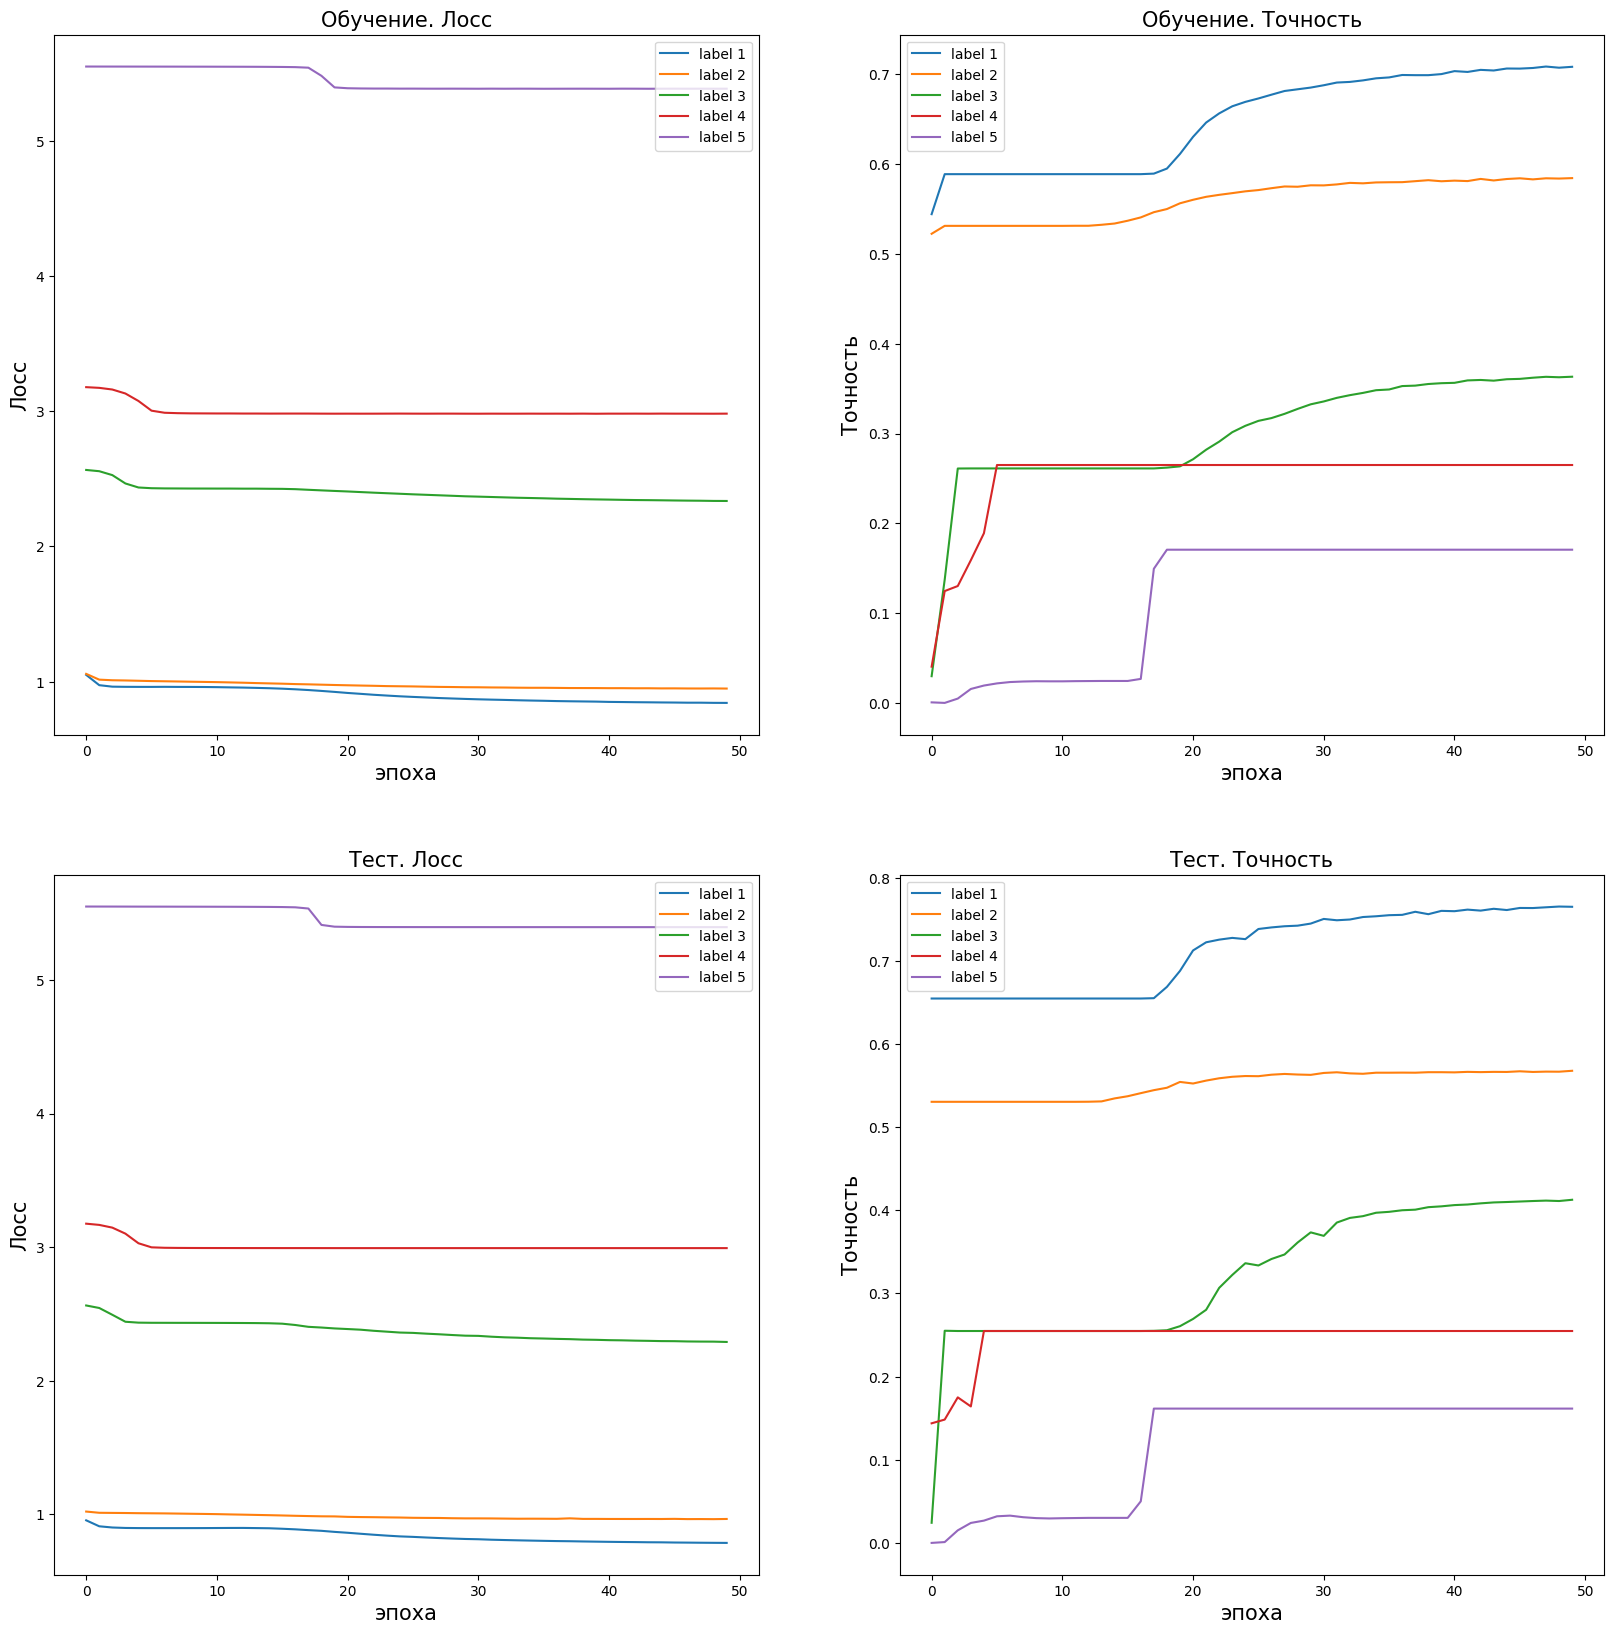

0
12800
25600
38400


KeyboardInterrupt: ignored

In [78]:
for epoch in range(150):
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_dataloader, criterion)
    data = updata(data)

    clear_output()

    print(f'Epoch: {epoch+1}')
    print(f'Train loss: {train_loss}')
    print(f'Train accuracy: {train_accuracy}')
    print(f'Test loss: {test_loss}')
    print(f'Test accuracy: {test_accuracy}')
    plot_learning_curves(data)

## Итоги
- В эксперименте 3 используется похожая модель, только кроме предобученной модели Berd используется слой эмбендингов и LSTM, результаты тоже не очень хорошие.

## Что еще можно было бы сделать
- Оставить предобученный Berd и выходные слои